# Time Series Exploration of Pick data

### Environment setup

In [1]:
import acquire
import prepare
import wrangle_pick
import summarize
import explore
import model

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Wrangle

In [2]:
train, test, validate = wrangle_pick.wrangle_pick_data()
train.shape, test.shape, validate.shape

Acquire: downloading raw data files...
Acquire: Completed!
Prepare: Cleaning acquired data...
Prepare: Completed!


((96634, 16), (20063, 16), (17054, 16))

In [3]:
# create df for explore
exp = train.copy()

In [4]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   operator       96634 non-null  object         
 1   total_lines    96634 non-null  int64          
 2   total_boxes    96634 non-null  int64          
 3   start          96634 non-null  datetime64[ns] 
 4   end            96634 non-null  datetime64[ns] 
 5   pick_time      96634 non-null  timedelta64[ns]
 6   pick_seconds   96634 non-null  int64          
 7   day            96634 non-null  int64          
 8   day_name       96634 non-null  object         
 9   year           96634 non-null  int64          
 10  month          96634 non-null  int64          
 11  week           96634 non-null  int64          
 12  hour           96634 non-null  int64          
 13  sec_per_box    96634 non-null  float64        
 14  lines_per_box  96634 non-null  float64        
 1

In [5]:
# create df for time series exploration
ts = train.copy()

# Non-TS index Explore

## Prep explore dataframe

In [6]:
exp1 = exp[['total_lines', 'total_boxes', 'pick_seconds', 'operator', 'hour', 'day', 'day_name', 
            'week', 'month', 'year', 'sec_per_box', 'lines_per_box', 'sec_per_line' ]]

In [7]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


In [8]:
exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_lines    96634 non-null  int64  
 1   total_boxes    96634 non-null  int64  
 2   pick_seconds   96634 non-null  int64  
 3   operator       96634 non-null  object 
 4   hour           96634 non-null  int64  
 5   day            96634 non-null  int64  
 6   day_name       96634 non-null  object 
 7   week           96634 non-null  int64  
 8   month          96634 non-null  int64  
 9   year           96634 non-null  int64  
 10  sec_per_box    96634 non-null  float64
 11  lines_per_box  96634 non-null  float64
 12  sec_per_line   96634 non-null  float64
dtypes: float64(3), int64(8), object(2)
memory usage: 10.3+ MB


In [9]:
# export this dataframe for exploring in Tableau
exp1.to_csv('exp1.csv')

In [10]:
exp1 = pd.read_csv('exp1.csv', index_col=0)
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


### check for observations where pick_seconds is 0

- none where seconds is 0 or 1, only 1 records where time is 2 seconds

In [11]:
exp1[exp1.pick_seconds==2]

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line


## create visualizations

**DEFINITIONS**     
- each observation is 1 order to fulfill
- the number of lines is the number of (unique?) items to put in the box
- each order is a minimum of 1 box, though more boxes may be needed
    - check if lines are higher on multiple box orders
    - compare mean pick times for multiple box orders

### does the total lines vary by hour of day?
- operating hours start at 7a and end at 6p
- lines are lightest at beginning and end of day with a spike around 5p

<AxesSubplot:xlabel='hour', ylabel='total_lines'>

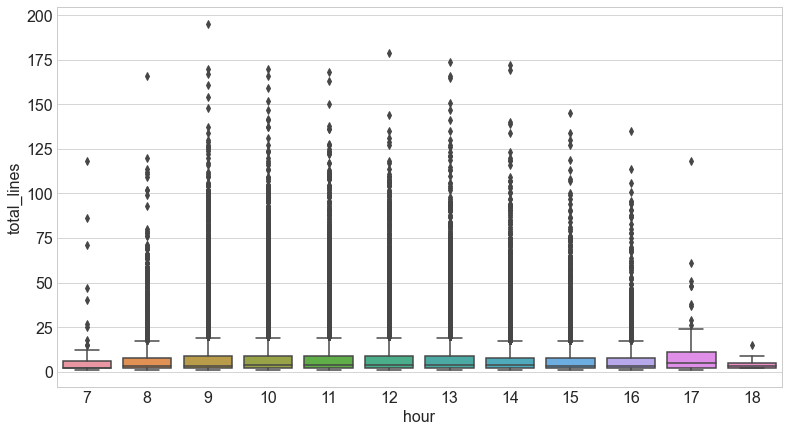

In [12]:
sns.boxplot(data=exp1, y='total_lines', x='hour')

### does the total lines vary by day of week?
- not much on average, but there seem to be a lot of outliers?

<AxesSubplot:xlabel='day_name', ylabel='total_lines'>

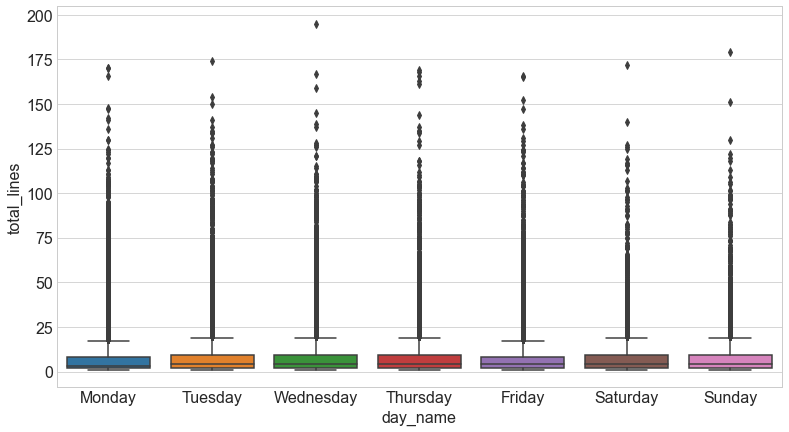

In [13]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_lines', x='day_name', order=order)

### does the total lines vary by day of month?
- some variation on average by day of month
- first 4 days of month tend to be higher
- final days of month tend to be lower

<AxesSubplot:xlabel='day', ylabel='total_lines'>

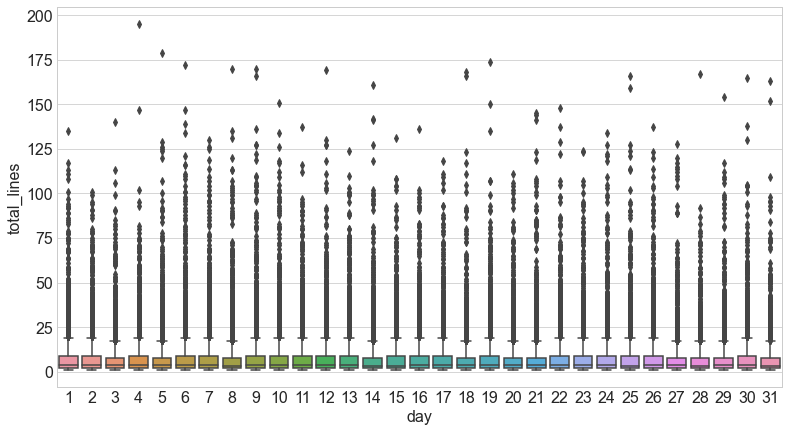

In [14]:
sns.boxplot(data=exp1, y='total_lines', x='day')

### does the total lines vary by week of year?
- Christmas and Thanksgiving weeks are lighter
- weeks at beginning of months are generally larger and weeks at end of month fewer

<AxesSubplot:xlabel='week', ylabel='total_lines'>

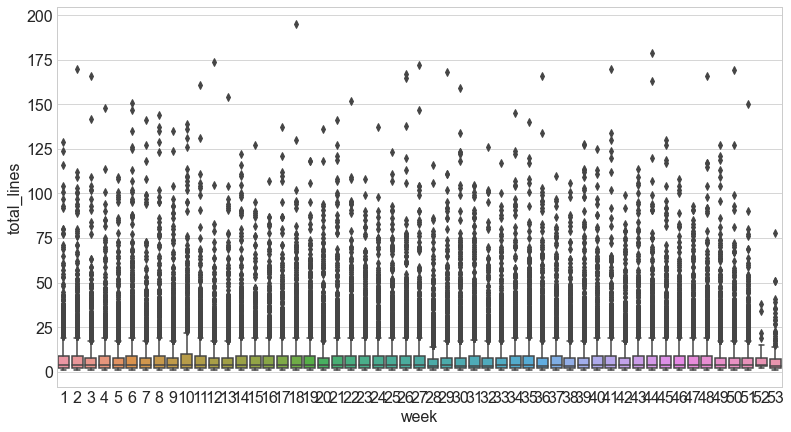

In [15]:
sns.boxplot(data=exp1, y='total_lines', x='week')

### does the total lines vary by month of year?
- not really any variation by month

<AxesSubplot:xlabel='month', ylabel='total_lines'>

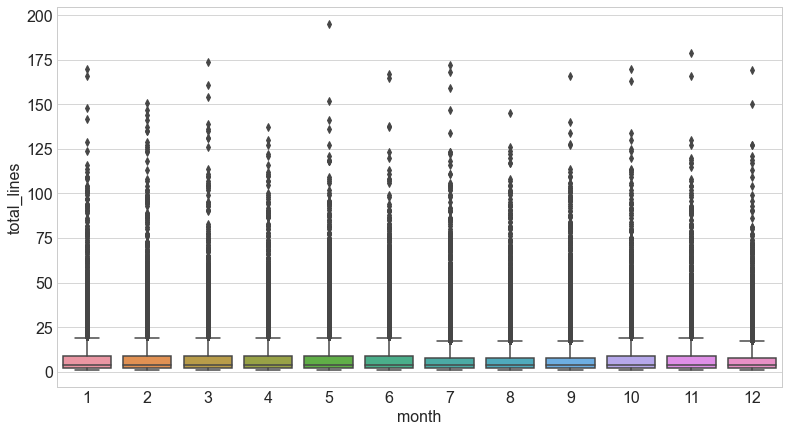

In [16]:
sns.boxplot(data=exp1, y='total_lines', x='month')

### does the total lines vary by year?
- not really any variation by year

<AxesSubplot:xlabel='year', ylabel='total_lines'>

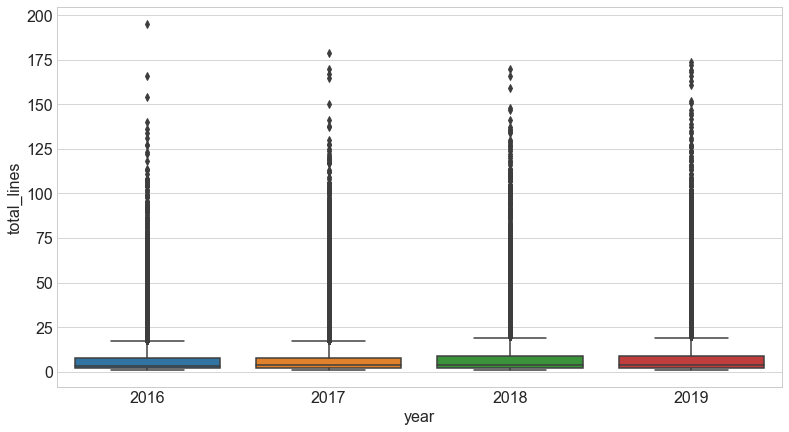

In [17]:
sns.boxplot(data=exp1, y='total_lines', x='year')

### does the total boxes vary by day of week?
- only outliers?
- typically the boxes per pick is 1 so this may not be a good feature for analysis
- might need to treat values <1 as anomalies and remove from dataset?
    - yes, picks with 0 boxes returned 7 observations that are anomalies and will be removed for this round
- visualization also shows total_boxes over 20 as anomalies


<AxesSubplot:xlabel='day_name', ylabel='total_boxes'>

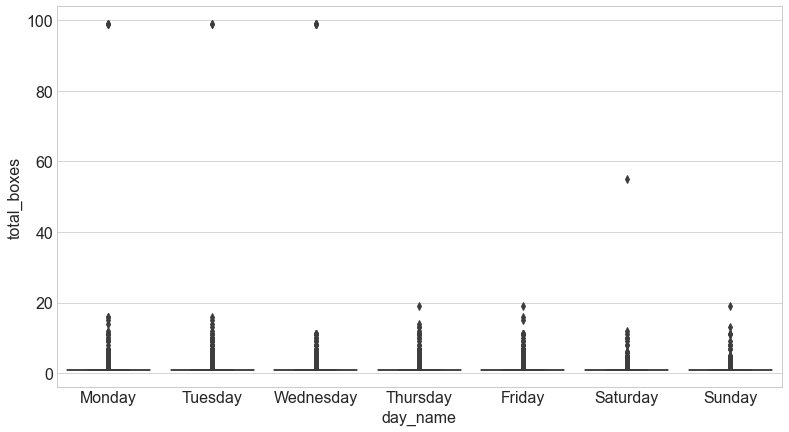

In [18]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_boxes', x='day_name', order=order)

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line


# Time Series Explore

## Prepare time series dataframe

In [20]:
ts.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [21]:
# create a dataframe with start as index and total lines, total boxes, and pick seconds as target
# these can all be aggregated by sum for resampling
pick = ts[['start', 'total_lines', 'total_boxes', 'pick_seconds']]
# set the index as start and sort for time series analysis
pick = pick.set_index('start').sort_index()

In [22]:
pick.head()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:39:12,5,1,17
2016-01-02 09:42:55,2,1,22
2016-01-02 09:44:54,2,1,79
2016-01-02 09:47:42,2,1,27
2016-01-02 09:53:08,11,1,173


## Basic range and histograms

without resampling

In [23]:
pick.index.min(), pick.index.max()

(Timestamp('2016-01-02 09:39:12'), Timestamp('2019-12-24 11:08:01'))

array([[<AxesSubplot:title={'center':'total_lines'}>,
        <AxesSubplot:title={'center':'total_boxes'}>],
       [<AxesSubplot:title={'center':'pick_seconds'}>, <AxesSubplot:>]],
      dtype=object)

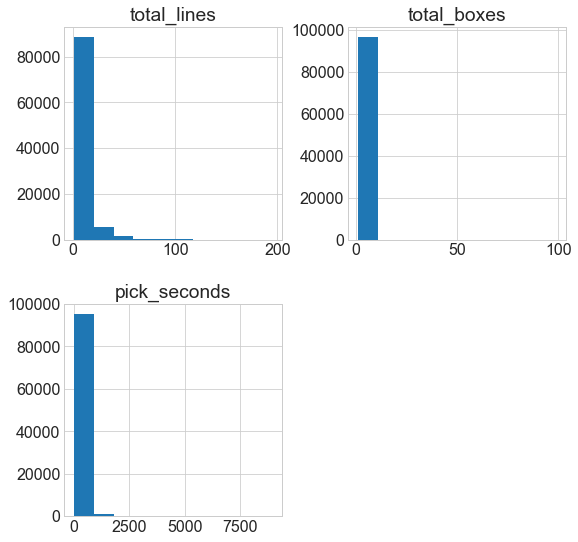

In [24]:
pick.hist(figsize=(9, 9))

<AxesSubplot:xlabel='start'>

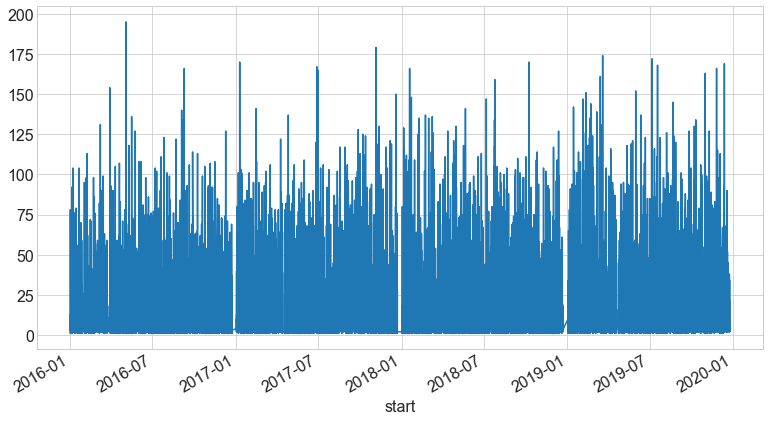

In [25]:
pick.total_lines.plot()

<AxesSubplot:xlabel='start'>

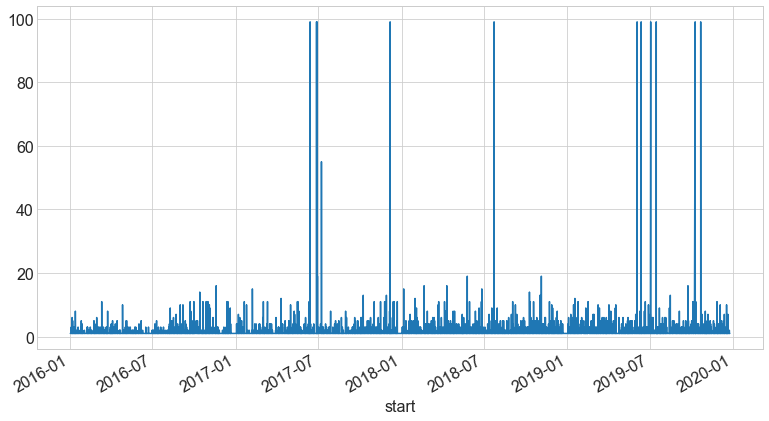

In [26]:
pick.total_boxes.plot()

<AxesSubplot:xlabel='start'>

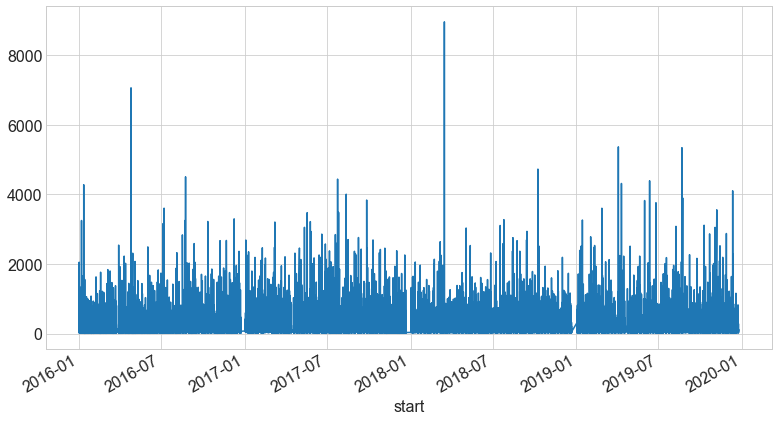

In [27]:
pick.pick_seconds.plot()

## Find anomalies in pick seconds

In [28]:
# get a df with just timeseries index and target
# for outlier dection sum by day to start (might need to do by hour if not granular enough)
pick_sec = pick[['pick_seconds']].resample('1d').sum()

In [29]:
pick_sec.head()

,pick_seconds
start,
2016-01-02,12975
2016-01-03,11130
2016-01-04,15256
2016-01-05,0
2016-01-06,11723


### Simple Moving Average

In [30]:
# get the 7 day rolling average
sma_short = pick_sec.rolling(window=7).mean()
# get the 30 day rolling average
sma_long = pick_sec.rolling(window=30).mean()

Text(0, 0.5, 'pick_sec')

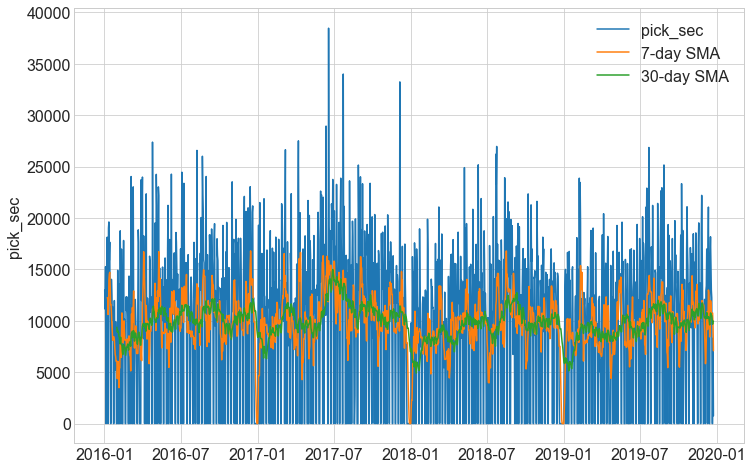

In [31]:
# plot these
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, pick_sec, label='pick_sec')

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

### Exponential Moving Average

In [32]:
# use ewm to calculate EMA
ema_short = pick_sec.ewm(span=7).mean()
ema_long = pick_sec.ewm(span=30).mean()

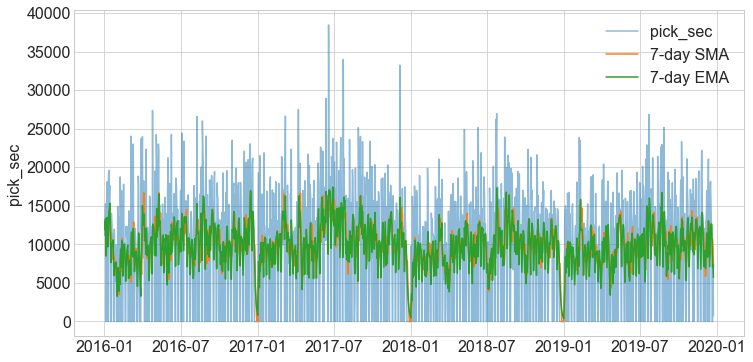

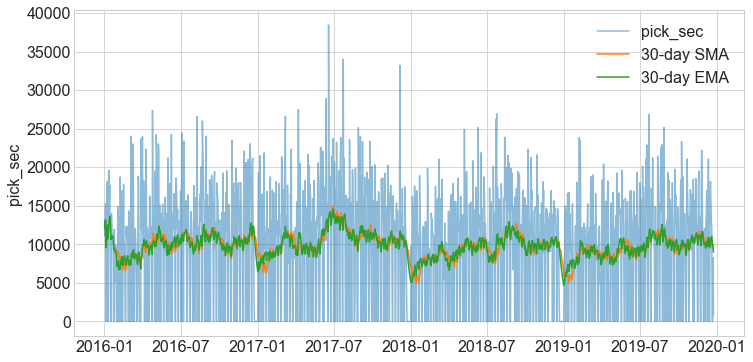

In [33]:
# plot these with SMA

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_short, label = '7-day SMA')
ax.plot(pick_sec.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pick_sec.index, pick_sec, label='pick_sec', alpha=.5)

ax.plot(pick_sec.index, sma_long, label = '30-day SMA')
ax.plot(pick_sec.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

plt.show()

### Bolinger bands and %b

In [34]:
# set the window span - in this case 30 days
span = 30
# compute midband
midband = pick_sec.ewm(span=span).mean()
# compute exponential stdev
stdev = pick_sec.ewm(span=span).std()
# compute upper and lower bands, multiple the midband +/- 1.5 times the standard deviation
ub = midband + stdev*1.5
lb = midband - stdev*1.5
# NOTE: lower band would actually be zero, as it is not possible to have neagtive a pick time

Text(0, 0.5, 'pick_sec')

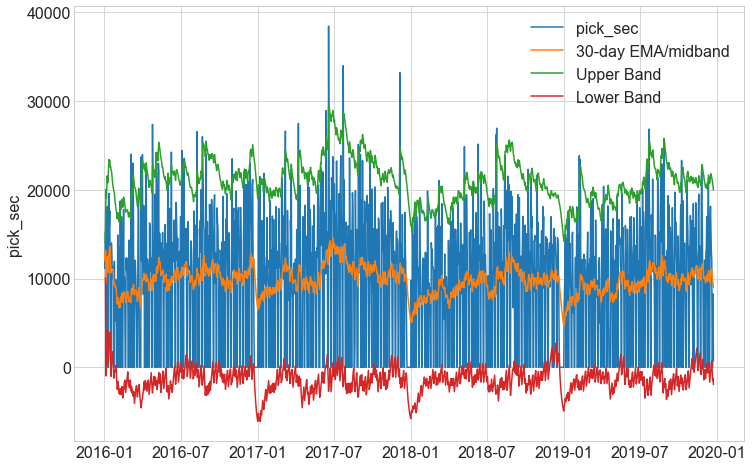

In [35]:
# plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pick_sec.index, 
        pick_sec,
        label='pick_sec')

ax.plot(pick_sec.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(pick_sec.index, 
        ub, 
        label = 'Upper Band')
ax.plot(pick_sec.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('pick_sec')

In [36]:
# concat the dataframes together
pick_sec_sum = pd.concat([pick_sec, midband, ub, lb], axis=1)
pick_sec_sum.columns = ['pick_sec', 'midband', 'ub', 'lb']
pick_sec_sum.tail()

,pick_sec,midband,ub,lb
start,,,,
2019-12-20,12213,11044.423202,21377.301332,711.545072
2019-12-21,0,10331.879769,21149.253564,-485.494025
2019-12-22,0,9665.306881,20821.559123,-1490.945361
2019-12-23,8284,9576.190308,20378.976730,-1226.596114
2019-12-24,750,9006.758675,19966.442414,-1952.925063


In [37]:
# add a calculated column for %b
pick_sec_sum['pct_b'] = (pick_sec_sum['pick_sec'] - pick_sec_sum['lb'])/(pick_sec_sum['ub'] - pick_sec_sum['lb'])

In [38]:
# show anywhere %b is more than 1 = outside the upper band
len(pick_sec_sum[pick_sec_sum['pct_b']>1])

44

In [39]:
# show anywhere %b is less than .1 = right at the lower band
len(pick_sec_sum[pick_sec_sum['pct_b']<.1])

270

In [40]:
pick_sec_sum[pick_sec_sum['pct_b']<.1]

,pick_sec,midband,ub,lb,pct_b
start,,,,,
2016-01-05,0,9542.979735,20055.551496,-969.592025,0.046116
2016-01-10,0,10718.483930,21038.249606,398.718254,-0.019318
2016-01-16,0,11796.952892,22657.787307,936.118476,-0.043096
2016-01-17,0,10636.717615,22286.784669,-1013.349440,0.043491
2016-01-23,0,10115.233819,20143.052963,87.414675,-0.004359
...,...,...,...,...,...
2019-12-10,0,9718.250308,20079.054175,-642.553559,0.031009
2019-12-14,0,10191.713354,21093.665049,-710.238341,0.032574
2019-12-15,0,9534.183460,20749.187114,-1680.820194,0.074936


**takeaways**
- with 3 as the multiplier there are no results outside of the bands
- changing multiplier to 1.5
- drop 274 days with a pick time of 0 sec?
    - these are Saturdays, holidays, and possibly inventory days based on dates
    - they are generated from resampling 
    
- there are 51 rows with pick times above the upper band at 1.5
    - but this is a sum of the total pick seconds per day, these may be a result of adding operators to that day?
    - would need to add %b values to df with operators and look at those specific days
    - especially given they are within range when multiplier is 3

## Resample by Hour - RETURN HERE

In [41]:
pick.resample('H').sum()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02 09:00:00,41,7,548
2016-01-02 10:00:00,132,21,2227
2016-01-02 11:00:00,212,18,3873
2016-01-02 12:00:00,115,18,1487
2016-01-02 13:00:00,196,17,3165
...,...,...,...
2019-12-24 07:00:00,0,0,0
2019-12-24 08:00:00,6,2,145
2019-12-24 09:00:00,0,0,0


In [42]:
pick.isna().sum()

total_lines     0
total_boxes     0
pick_seconds    0
dtype: int64

## Resample by Day

In [43]:
pick.resample('D').sum()

,total_lines,total_boxes,pick_seconds
start,,,
2016-01-02,806,106,12975
2016-01-03,714,119,11130
2016-01-04,431,79,15256
2016-01-05,0,0,0
2016-01-06,671,98,11723
...,...,...,...
2019-12-20,687,109,12213
2019-12-21,0,0,0
2019-12-22,0,0,0
